<a href="https://colab.research.google.com/github/seyong2/kaggle-digit-recognizer/blob/main/Digit_Recognizer_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook is an extension of a previous notebook whose goal was to correctly identify digits in a dataset of tens of thousands of handwritten images published by the "Modified National Institute of Standards and Technology" (MNIST). Although we used a very simple neural network and the algorithm achieves high generalization performance, we will create a convolutional neural network (CNN) to see if it can improve the neural network model. You can read more about this digit recognizer competition [here](https://www.kaggle.com/competitions/digit-recognizer/overview).

Then let's get started by importing all the necessary libraries and data.

# 1. Import Python libraries and Data

In [1]:
import numpy as np
import pandas as pd

# visualization
import matplotlib.pyplot as plt
%matplotlib inline

import random
! pip install torchmetrics
import torch, torchmetrics
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 512 kB 34.4 MB/s 


In [2]:
# Install the Kaggle library
! pip install kaggle

# Make a directory named ".kaggle"
! mkdir ~/.kaggle

# Copy the "kaggle.json" into this new directory
! cp kaggle.json ~/.kaggle/

# Allocate the required permission for this file
! chmod 600 ~/.kaggle/kaggle.json

! kaggle competitions download -c digit-recognizer

! unzip digit-recognizer.zip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
 98% 15.0M/15.3M [00:01<00:00, 17.4MB/s]
100% 15.3M/15.3M [00:01<00:00, 9.64MB/s]
Archive:  digit-recognizer.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


# 2. Load Training and Testing Data

In [3]:
# read 'train.csv' and 'test.csv' which are comma-separated values (csv) file into DataFrame.
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [4]:
# see the shape of train_df and test_df
print(f"The training data has {train_df.shape[0]} rows and {train_df.shape[1]} columns.")
print(f"The testing data has {test_df.shape[0]} rows and {test_df.shape[1]} columns.")

The training data has 42000 rows and 785 columns.
The testing data has 28000 rows and 784 columns.


In [5]:
# the first five rows of train_df
train_df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
# the first five rows of test_df
test_df.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


The training and test data contain 42,000 and 28,000 grayscale images of hand-drawn digits from 0 to 9, respectively. The training data has one more column than the test data because the first column, `label`, represents the number the user wrote.

Each images has 784 pixels (28 pixels in height and 28 pixels in width), which corresponds to the number of remaining columns. Each pixel value ranges from 0 to 255, indicating the brightness of the corresponding pixel, and the higher the value, the darker it is.

Let's see how many images are in each class.

In [7]:
# the number of images in the digit classes
train_df['label'].value_counts()

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

The images seem to be more or less evenly distributed across the digit classes. And since there are 10 different image classes (different types of numbers), it is a multi-class classification problem.

# 3. Transform Data and Prepare DataLoader

Before using the data in PyTorch, we need to turn them into tensors (multi-dimensional matrices containing elements of a single data type) and subsequently a Python iterable using `torch.utils.data.DataLoader`,


In [8]:
# convert dataframe to numpy array
train_arr = train_df.to_numpy()

# separate 'train_arr' into X (pixels) and y (label)
X = train_arr[:, 1:].reshape((train_df.shape[0], 28, 28, 1)).astype(np.uint8) # NCHW (Number of Images, Color Channels, Height, Width)
y = train_arr[:, 0]

According to [`ToTensor()`](https://pytorch.org/vision/stable/generated/torchvision.transforms.ToTensor.html#torchvision.transforms.ToTensor), a PIL Image or `numpy.ndarray` (H x W x C) in the range [0, 255] is converted to a `torch.FloatTensor` of shape (C x H x W) in the range [0.0, 1.0] if the PIL Image belongs to one of the modes (L, LA, P, I, F, RGB, YCbCr, RGBA, CMYK, 1) or if the `numpy.ndarray` has `np.uint8` as data type. That's why we converted `train_df` to a Numpy array with a new shape of (42000, 28, 28, 1) and data type of `np.unit8`.

In [9]:
# create 'data_transform' that converts X into tensors and resizes them to (32, 32)
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(size=(32, 32))
])

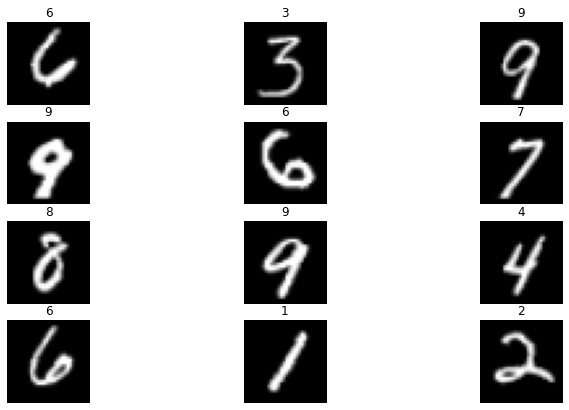

In [10]:
# plot 12 random images
torch.manual_seed(42)

fig = plt.figure(figsize=(12, 7))
rows, cols = 4, 3

for i in range(1, rows*cols+1):
  # generate random integer between 0 and the length of data
  random_idx = torch.randint(0, len(X), size=[1]).item()
  # transform the selected image
  img = data_transform(X[random_idx])
  label = y[random_idx]
  fig.add_subplot(rows, cols, i)
  plt.imshow(img.squeeze(), cmap='gray')
  plt.title(label)
  plt.axis(False);

Above, 12 random images of handwritten digits are visualized after the data was converted to tensors and resized.

Now, we are ready to prepare the DataLoader which helps turn a large dataset into a Python iterable of smaller mini-batches. One of the advantages of using mini-batches to train a model is that it requires less memory because the model is trained with less data.


Source - [What is batch size in neural network?](https://stats.stackexchange.com/questions/153531/what-is-batch-size-in-neural-network) 

In [11]:
class DigitRecognizerTrainDataset(torch.utils.data.Dataset):
    def __init__(self):
      self.dataset = train_df[:28000].to_numpy()

    def __getitem__(self, idx):
        sample = self.dataset[idx]
        features, label = sample[1:], sample[0]
        features = features.reshape((28, 28, 1)).astype(np.uint8)
        
        transform = data_transform
        return transform(features), torch.tensor(label)

    def __len__(self):
        return len(self.dataset)

class DigitRecognizerTestDataset(torch.utils.data.Dataset):
    def __init__(self):
      self.dataset = train_df[28000:].to_numpy()

    def __getitem__(self, idx):
        sample = self.dataset[idx]
        features, label = sample[1:], sample[0]
        features = features.reshape((28, 28, 1)).astype(np.uint8)
        
        transform = data_transform
        return transform(features), torch.tensor(label)

    def __len__(self):
        return len(self.dataset)

train_set = DigitRecognizerTrainDataset()
test_set = DigitRecognizerTestDataset()

In [12]:
# create dataloaders for train and test data

# set up batch size
batch_size = 32

# turn datasets into batches
train_dataloader = DataLoader(train_set,
                              batch_size=batch_size,
                              shuffle=True)

test_dataloader = DataLoader(test_set,
                             batch_size=batch_size,
                             shuffle=False)

print(f"There are {len(train_dataloader)} batches of size {batch_size} in train dataloader.")
print(f"There are {len(test_dataloader)} batches of size {batch_size} in test dataloader.")

There are 875 batches of size 32 in train dataloader.
There are 438 batches of size 32 in test dataloader.


When creating the dataloader, we need to select a value for the hyperparameter `batch_size`. We set it to 32, which means there are 32 samples in each batch.

In [13]:
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 32, 32]), torch.Size([32]))

# 4. Modeling

Now that the training and test data loaders are ready, we will build a CNN model by subclassing `nn.Module` (the base class for all neural network modules).

The CNN model we will be using is the MiniVGGNet from [MiniVGGNet: Going Deeper with CNNs](https://pyimagesearch.com/2021/05/22/minivggnet-going-deeper-with-cnns/).'

Following the general structure of CNNs, what makes VGGNet unique is that it only uses 3$\times$3 kernels from start to finish, unlike other models that starts with a filter size between 7$\times$7 and 11$\times$11 and gradually reduces the kernel size to 3$\times$3.

Instead of trying a variant with 16 to 19 layers, we will replicate a smaller version of VGGNet called MiniVGGNet. For more details on the architecture of the MiniVGGNet, see [MiniVGGNet: Going Deeper with CNNs](https://pyimagesearch.com/2021/05/22/minivggnet-going-deeper-with-cnns/).

In [19]:
# construct a cnn
class DigitRecognizerMiniVGGNet(nn.Module):
  def __init__(self):
    super().__init__()
    # first set of conv -> relu -> conv -> relu -> pool
    self.block_1 = nn.Sequential(
        nn.Conv2d(in_channels=1,
                  out_channels=32,
                  kernel_size=3,
                  stride=1,
                  padding='same'),
        nn.ReLU(),
        nn.BatchNorm2d(32),
        nn.Conv2d(in_channels=32,
                  out_channels=32,
                  kernel_size=3,
                  stride=1,
                  padding='same'),
        nn.ReLU(),
        nn.BatchNorm2d(32),
        nn.MaxPool2d(kernel_size=2),
        nn.Dropout(p=0.25) 
    )
    # second set of conv -> relu -> conv -> relu -> pool
    self.block_2 = nn.Sequential(
        nn.Conv2d(in_channels=32,
                  out_channels=64,
                  kernel_size=3,
                  padding='same'),
        nn.ReLU(),
        nn.BatchNorm2d(64),
        nn.Conv2d(in_channels=64,
                  out_channels=64,
                  kernel_size=3,
                  padding='same'),
        nn.ReLU(),
        nn.BatchNorm2d(64),
        nn.MaxPool2d(kernel_size=2),
        nn.Dropout(p=0.25)
    )
    self.block_3 = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=4096,
                  out_features=4096),
        nn.ReLU(),
        nn.BatchNorm1d(4096),
        nn.Dropout(p=0.5)
    )
    self.block_4 = nn.Sequential(
        nn.Linear(in_features=4096,
                  out_features=10),
        #nn.Softmax(dim=1)
    )
  def forward(self, x):
    return self.block_4(self.block_3(self.block_2(self.block_1(x))))

Let's instantiate a model with `DigitRecognizerMiniVGGNet`. But before that, we will set up device-agnostic code for the model and data to run on GPU if it's available.

In [15]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [20]:
# instantiate the model and send it to GPU
torch.manual_seed(42)

model = DigitRecognizerMiniVGGNet()
model.to(device)

DigitRecognizerMiniVGGNet(
  (block_1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (4): ReLU()
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.25, inplace=False)
  )
  (block_2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (4): ReLU()
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)


Before training the model, we need to set up the appropriate loss, optimization, and evaluation metrics since we are dealing with a multi-classification problem.

For evaluation, we use `torchmetrics.Accuracy`, which computes the fraction of correct predictions by the model. If predictions are floating points, it applies `torch.argmax` along the label classes to automatically convert probabilities/logits into an int tensor.

For the loss function, the cross-entropy loss does the work and the Stochastic Gradient Descent (SGD) algorithm is used as the optimizer.

Source - [Cross-Entropy Loss](https://www.youtube.com/watch?v=6ArSys5qHAU), [SGD](https://www.youtube.com/watch?v=vMh0zPT0tLI)

In [22]:
# set up accuracy function, loss function and optimizer
acc_fn = torchmetrics.Accuracy(task='multiclass', num_classes=10).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.1)

We are now ready to train the model! 

In [25]:
# set the seed
torch.manual_seed(42)

# set the number of epochs
epochs = 40

train_loss_list = []
train_acc_list = []
test_loss_list = []
test_acc_list = []

# create training and testing loop
for epoch in range(epochs):
  print(f"Epoch: {epoch+1}/{epochs}\n------")
  
  # training
  train_loss, train_acc = 0, 0
  for batch, (X, y) in enumerate(train_dataloader):
    # send data to GPU
    X, y  = X.to(device), y.to(device)
    model.train()
    # forward pass
    y_pred = model(X)
    # compute loss and accuracy (per batch)
    loss = loss_fn(y_pred, y)
    train_loss += loss
    train_acc += acc_fn(torch.argmax(torch.softmax(y_pred, dim=1), dim=1), y)
    # optimizer zero grad
    optimizer.zero_grad()
    # loss backward
    loss.backward()
    # optimizer step
    optimizer.step()

  train_loss /= len(train_dataloader)
  train_acc /= len(train_dataloader)
  train_loss_list.append(train_loss)
  train_acc_list.append(train_acc)

  # testing
  test_loss, test_acc = 0, 0
  model.eval()
  with torch.inference_mode():
    for X, y in test_dataloader:
      # send data to GPU
      X, y  = X.to(device), y.to(device)
      # forward pass
      test_pred = model(X)
      # compute loss
      test_loss += loss_fn(test_pred, y)
      # compute accuracy
      test_acc += acc_fn(torch.argmax(torch.softmax(test_pred, dim=1), dim=1), y)
    test_loss /= len(test_dataloader)
    test_acc /= len(test_dataloader)
    test_loss_list.append(test_loss)
    test_acc_list.append(test_acc)
  print(f"Train loss: {train_loss:.4f}, Train acc: {train_acc:.2f}% | Test loss: {test_loss:.4f}, Test acc: {test_acc:.2f}%\n")

Epoch: 1/40
------
Train loss: 0.0158, Train acc: 1.00% | Test loss: 0.1772, Test acc: 0.99%

Epoch: 2/40
------
Train loss: 0.0126, Train acc: 1.00% | Test loss: 0.3211, Test acc: 0.99%

Epoch: 3/40
------
Train loss: 0.0125, Train acc: 1.00% | Test loss: 0.2013, Test acc: 0.99%

Epoch: 4/40
------
Train loss: 0.0090, Train acc: 1.00% | Test loss: 0.1881, Test acc: 0.99%

Epoch: 5/40
------
Train loss: 0.0235, Train acc: 1.00% | Test loss: 0.2164, Test acc: 0.99%

Epoch: 6/40
------
Train loss: 0.1282, Train acc: 0.99% | Test loss: 0.1739, Test acc: 0.99%

Epoch: 7/40
------
Train loss: 0.1051, Train acc: 0.99% | Test loss: 0.1700, Test acc: 0.99%

Epoch: 8/40
------
Train loss: 0.1568, Train acc: 0.98% | Test loss: 0.1582, Test acc: 0.99%

Epoch: 9/40
------
Train loss: 0.1039, Train acc: 0.99% | Test loss: 0.1401, Test acc: 0.99%

Epoch: 10/40
------
Train loss: 0.0941, Train acc: 0.99% | Test loss: 0.1638, Test acc: 0.99%

Epoch: 11/40
------
Train loss: 0.0975, Train acc: 0.99% | 

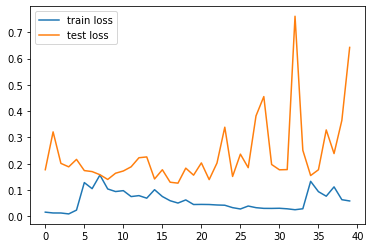

In [48]:
# plot train and test loss
train_losses = [i.cpu().item() for i in train_loss_list]
test_losses = [i.cpu().item() for i in test_loss_list]

plt.plot(range(0, epochs), train_losses, label='train loss')
plt.plot(range(0, epochs), test_losses, label='test loss')

plt.legend()
plt.show()

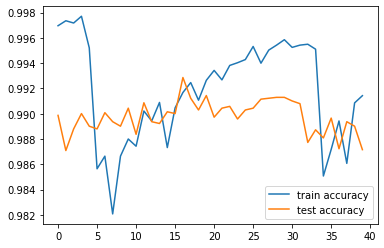

In [46]:
# plot train and test accuracy
train_accs = [i.cpu().item() for i in train_acc_list]
test_accs = [i.cpu().item() for i in test_acc_list]

plt.plot(range(0, epochs), train_accs, label='train accuracy')
plt.plot(range(0, epochs), test_accs, label='test accuracy')

plt.legend()
plt.show()

The first indicate that after 9 epochs the loss of test data reached a near-minimum value. After that point, the loss fluctuates but does not decrease significantly. Looking at the test accuracies, they tend to be around 0.99. So we will train the model up to 9 epochs and make predictions on the real test data with that model.

In [49]:
# set the seed
torch.manual_seed(42)

# set the number of epochs
epochs = 9

# create training and testing loop
for epoch in range(epochs):
  print(f"Epoch: {epoch+1}/{epochs}\n------")
  
  # training
  train_loss, train_acc = 0, 0
  for batch, (X, y) in enumerate(train_dataloader):
    # send data to GPU
    X, y  = X.to(device), y.to(device)
    model.train()
    # forward pass
    y_pred = model(X)
    # compute loss and accuracy (per batch)
    loss = loss_fn(y_pred, y)
    train_loss += loss
    train_acc += acc_fn(torch.argmax(torch.softmax(y_pred, dim=1), dim=1), y)
    # optimizer zero grad
    optimizer.zero_grad()
    # loss backward
    loss.backward()
    # optimizer step
    optimizer.step()

  train_loss /= len(train_dataloader)
  train_acc /= len(train_dataloader)

  # testing
  test_loss, test_acc = 0, 0
  model.eval()
  with torch.inference_mode():
    for X, y in test_dataloader:
      # send data to GPU
      X, y  = X.to(device), y.to(device)
      # forward pass
      test_pred = model(X)
      # compute loss
      test_loss += loss_fn(test_pred, y)
      # compute accuracy
      test_acc += acc_fn(torch.argmax(torch.softmax(test_pred, dim=1), dim=1), y)
    test_loss /= len(test_dataloader)
    test_acc /= len(test_dataloader)

  print(f"Train loss: {train_loss:.4f}, Train acc: {train_acc:.2f}% | Test loss: {test_loss:.4f}, Test acc: {test_acc:.2f}%\n")

Epoch: 1/9
------
Train loss: 0.0170, Train acc: 1.00% | Test loss: 0.2533, Test acc: 0.99%

Epoch: 2/9
------
Train loss: 0.0117, Train acc: 1.00% | Test loss: 0.4838, Test acc: 0.99%

Epoch: 3/9
------
Train loss: 0.0090, Train acc: 1.00% | Test loss: 0.3187, Test acc: 0.99%

Epoch: 4/9
------
Train loss: 0.0119, Train acc: 1.00% | Test loss: 0.3237, Test acc: 0.99%

Epoch: 5/9
------
Train loss: 0.0105, Train acc: 1.00% | Test loss: 0.7686, Test acc: 0.99%

Epoch: 6/9
------
Train loss: 0.0170, Train acc: 1.00% | Test loss: 0.4036, Test acc: 0.99%

Epoch: 7/9
------
Train loss: 0.0146, Train acc: 1.00% | Test loss: 0.2649, Test acc: 0.99%

Epoch: 8/9
------
Train loss: 0.0113, Train acc: 1.00% | Test loss: 0.2600, Test acc: 0.99%

Epoch: 9/9
------
Train loss: 0.0159, Train acc: 1.00% | Test loss: 0.2330, Test acc: 0.99%



# 5. Making Predictions on the Data for Submission

The final step is to make predictions on the test dataset and submit our predictions to see how accurate they are.

In [55]:
class DigitRecognizerSubmissionDataset(torch.utils.data.Dataset):
    def __init__(self):
      self.dataset = test_df.to_numpy()

    def __getitem__(self, idx):
        features = self.dataset[idx]
        features = features.reshape((28, 28, 1)).astype(np.uint8)
        
        return data_transform(features)

    def __len__(self):
        return len(self.dataset)

In [56]:
submission_set = DigitRecognizerSubmissionDataset()

In [57]:
submission_dataloader = DataLoader(submission_set,
                                   batch_size=len(submission_set),
                                   shuffle=False)

In [58]:
model.eval()
with torch.inference_mode():
  for X in submission_dataloader:
    label_logits = model(X.to(device))
    label_probs = torch.softmax(label_logits, dim=1)
    label = torch.argmax(label_probs, dim=1)

In [60]:
submission = pd.DataFrame(data=label.cpu().numpy(), index=range(1, 28001),columns=['Label'])
submission.index.name = 'ImageId'

In [61]:
submission.head()

,Label
ImageId,
1,2
2,0
3,9
4,0
5,3


In [62]:
submission.to_csv('submission_digit_recognizer_cnn.csv')